## Supervised omics experiments time annotation method with GPs

In [2]:
import pandas as pd
import numpy as np
import scipy.stats
import GPy
import matplotlib.pyplot as plt
GPy.plotting.change_plotting_library('matplotlib')
np.int = np.int32
np.float = np.float64
np.bool = np.bool_


def data_preprocessing_procedure(reference_time_series,
                                 target_experiments,
                                 filter_threshold = 10,
                                 epsilon = 0.1):
    '''
    Reads gene values matrices (dataframes) filters them by removing genes with small signal and normalizes them by log-transforming the values
    and subtracting the medians.

    :param reference_time_series: contains time series of positive gene values for the reference experiments
    :type reference_time_series: pandas DataFrame indexed by gene names. Each row is a time series of gene values and each column represents one replicate of a 
                                 sampled experiment at a given time.   

    :param target_experiments: contains genome-wide positive values for each target experiment
    :type target_experiments: pandas DataFrame indexed by gene names. Every column represents a target experiment

    :param filter_threshold: a value which determines whether we should remove or not a gene from our analysis. If all the values of a gene in the reference
    dataset are smaller than the threshold then the gene is removed.
    :type filter_threshold: float

    :param epsilon: a small quantity to add to the gene value to avoid errors when log-transforming the values
    :type epsilon: float

    :returns: (reference_time_series, target_experiments):

        :type reference_time_series: pandas DataFrame with normalized values for the reference experiments

        :type target_experiments: pandas DataFrame with normalized values for the target experiments

    '''

    reference_time_series = reference_time_series.loc[reference_time_series.max(axis=1) >= filter_threshold] 

    ###################

    common_genes = reference_time_series.index
    target_experiments = target_experiments.loc[common_genes]

    ####################################################

    reference_time_series = np.log(reference_time_series + epsilon)

    i=0
    while True:

        i=i+1
        last_sum_ref = reference_time_series.abs().sum().sum()
        last_sum_target = target_experiments.abs().sum().sum()

        #subtract to each gene the median of the current experiment
        reference_time_series = reference_time_series.sub(reference_time_series.median(axis = 0),axis = 1)
        target_experiments = target_experiments.sub(target_experiments.median(axis = 0), axis = 1)

        #subtract to each gene the median over all experiments of that gene
        reference_time_series = reference_time_series.sub(reference_time_series.median(axis = 1),axis = 0)
        target_experiments = target_experiments.sub(target_experiments.median(axis = 1), axis = 0)

        ref_red = np.abs(reference_time_series.abs().sum().sum()-last_sum_ref)/reference_time_series.abs().sum().sum()
        
        target_red = np.abs(target_experiments.abs().sum().sum()-last_sum_target)/target_experiments.abs().sum().sum()

        if target_red < 10**(-5) and ref_red < 10**(-5):
            break

    return reference_time_series, target_experiments, common_genes
    
    

def fitting_GPs (reference_time_series, 
                 target_experiments, 
                 time_points_covered, 
                 number_of_replicates, 
                 time_points_query,
                 ls_upper=12, 
                 ls_lower=1):
    
    '''
    Reads normalized gene values matrices (dataframes) of the reference experiments and target experiments. Fits GPs using the reference genes' time series
    and annotates the target experiments with a time point from the list of the queried time points using log-likelihood curves.
    
    :param reference_time_series: contains time series of positive gene values for the reference experiments
    :type reference_time_series: pandas DataFrame indexed by gene names. Each row is a time series of gene values and each column represents one replicate of a 
                                 sampled experiment at a given time.   
    
    
    :param target_experiments: contains genome-wide positive values for each target experiment
    :type target_experiments: pandas DataFrame indexed by gene names. Every column represents a target experiment


    :param time_points_covered: list of time points for which we have observations 
    :type time_points_covered: list
    
    :param number_of_replicates: the number of replicate measurements at each observed time point
    :type number_of_replicates: int
    
    :param time_points_query: list of time points for which we want to calculate the likelihood
    :type time_points_query: list
    
    :param ls_upper: upper bound constraint for the lengthscale
    :type ls_upper: int
    
    :param ls_lower: lower bound constraint for the lengthscale
    :type ls_lower: int
    
    :returns: (reference_time_series, target_experiments):
        
        :type reference_time_series: pandas DataFrame with normalized values for the reference experiments
        
        :type target_experiments: pandas DataFrame with normalized values for the target experiments
    
    '''
    
    time_points_query = np.array(time_points_query)[..., np.newaxis]
    
    X = np.array(time_points_covered*number_of_replicates)[...,np.newaxis]
    
    genes = target_experiments.index.values
    
    target_experiments_no = target_experiments.shape[1]
    
    log_probability_matrix = np.zeros((0,len(time_points_query), target_experiments_no)) # dims: 0x41x80
    
    
    time_invariant_log_lik_target = []
    time_invariant_log_lik_ref = []
    time_variant_log_lik_target = []
    gp_log_lik = []

    
    for g, ind in zip(genes, range(genes.size)):

        Y = reference_time_series.loc[g].values[...,np.newaxis]

        kernel = GPy.kern.RBF(input_dim=1, variance=0.5, lengthscale=4)
        kernel.lengthscale.constrain_bounded(lower = ls_lower, upper = ls_upper, warning=0)

        m = GPy.models.GPRegression(X,Y,kernel)

        m.optimize(messages=False)
        m.optimize_restarts(num_restarts = 1, verbose=0)
        
        m.plot()
        plt.savefig("results/plots/GP_models/GP_model_{}.jpg".format(g), bbox_inches='tight')
        plt.close()
        
        log_densities = m.log_predictive_density(x_test=time_points_query, y_test=target_experiments.loc[g].values[:,None].T) 
        log_probability_matrix = np.insert(log_probability_matrix, ind, log_densities, axis=0)
        
        
        ######
        time_invariant_log_lik_target.append(scipy.stats.norm(Y.mean(), np.sqrt(Y.var())).logpdf(target_experiments.loc[g]))
        mu, var = m.predict(np.array(time_points_covered)[...,np.newaxis])
        time_variant_log_lik_target.append([scipy.stats.norm(mu, np.sqrt(var)).logpdf(target_experiments.loc[g][i]).max() for i in range(target_experiments_no)])
        
        time_invariant_log_lik_ref.append(scipy.stats.norm(Y.mean(), np.sqrt(Y.var())).logpdf(Y).sum())
        gp_log_lik.append(m.log_likelihood())
        
        #####
        
    return log_probability_matrix, time_invariant_log_lik_target, time_variant_log_lik_target, time_invariant_log_lik_ref, gp_log_lik, target_experiments_no
    
    
    
def filter_bad_fitting_genes(time_invariant_log_lik_target,
                             time_variant_log_lik_target,
                             time_invariant_log_lik_ref, 
                             gp_log_lik,
                             common_genes,
                             epsilon_filter=2,):
    
        ###############    
        x = np.array([time_invariant_log_lik_target[i].sum() for i in range(len(common_genes))])
        y = np.array([sum(time_variant_log_lik_target[i]) for i in range(len(common_genes))])

        bad_fitting_genes_target = common_genes[ [y[i] < x[i] for i in range(len(common_genes))] ]
        ##############    
        
        ##############
        x = np.array(time_invariant_log_lik_ref)
        y = np.array(gp_log_lik)

        bad_fitting_genes_reference = common_genes[ [y[i] < x[i] - epsilon_filter for i in range(len(common_genes))] ]
        
        ##############
    
        bad_fitting_genes_all = set(bad_fitting_genes_reference).union(bad_fitting_genes_target)
    
        return bad_fitting_genes_target, bad_fitting_genes_reference, bad_fitting_genes_all
    
    
    
def time_prediction(target_experiments_no,
                             target_experiments,
                             time_points_query,
                             common_genes,
                             log_probability_matrix,
                             bad_fitting_genes_all): 
    
    log_probability_matrix = np.delete(log_probability_matrix,[list(common_genes).index(l) for l in bad_fitting_genes_all], axis=0 )

    predictions = []

    for i, exp in zip(range(target_experiments_no), target_experiments.columns):
        
        max_sum_index = log_probability_matrix[:,:,i].sum(axis=0).argmax()
        predictions.append(time_points_query[max_sum_index])
        
        plt.xlabel('time')
        plt.ylabel('log-likelihood')
        
        plt.plot(np.squeeze(time_points_query), log_probability_matrix[:,:,i].sum(axis=0), marker='.')
        plt.xticks(time_points_covered)
        
        plt.title("Target experiment: {} \n Maximum likelihood time point: {}\n".format(
            exp,  time_points_query[max_sum_index]))
        
        plt.savefig("results/plots/log_likelihood_plots/log_likelihood_curve_target_experiment{}.jpg".format(exp), bbox_inches='tight')
        plt.show()
    pd.DataFrame(data={'Target experiments': target_experiments.columns, 'Predictions': predictions}
                ).to_csv("results/target_experiments_predictions.csv")
    
    return predictions


def time_annotation_method(reference_time_series, 
                              target_experiments, 
                              time_points_covered, 
                              number_of_replicates, 
                              time_points_query,
                              common_genes,
                              ls_upper=12, 
                              ls_lower=1,
                              epsilon_filter=2):
    
    log_probability_matrix, time_invariant_log_lik_target, time_variant_log_lik_target, time_invariant_log_lik_ref, gp_log_lik, target_experiments_no = fitting_GPs(
                              reference_time_series=reference_time_series, 
                              target_experiments=target_experiments,  #
                              time_points_covered=time_points_covered, 
                              number_of_replicates=number_of_replicates, 
                              time_points_query=time_points_query,
                              ls_upper=12, 
                              ls_lower=1)
    
    bad_fitting_genes_target, bad_fitting_genes_reference, bad_fitting_genes_all = filter_bad_fitting_genes(epsilon_filter=epsilon_filter,
                             time_invariant_log_lik_target=time_invariant_log_lik_target,
                             time_variant_log_lik_target=time_variant_log_lik_target,
                             time_invariant_log_lik_ref=time_invariant_log_lik_ref, 
                             gp_log_lik=gp_log_lik,
                             common_genes=common_genes)
    
    predictions = time_prediction(target_experiments_no=target_experiments_no,
                             target_experiments=target_experiments, #
                             time_points_query=time_points_query,
                             common_genes=common_genes,
                             log_probability_matrix=log_probability_matrix,
                             bad_fitting_genes_all=bad_fitting_genes_all)
    
    return predictions

## Code example

In [8]:
reference_time_series = pd.read_csv("test_data/one_gene_operon_reference_experiments.csv", index_col=0)
target_experiments = pd.read_csv("test_data/target_experiments.csv", index_col=0)

reference_time_series, target_experiments, common_genes = data_preprocessing_procedure(reference_time_series.iloc[:50,:], target_experiments)

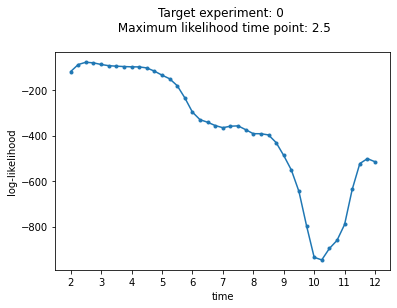

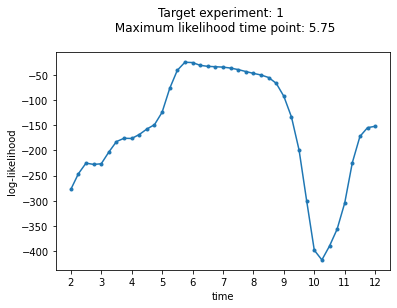

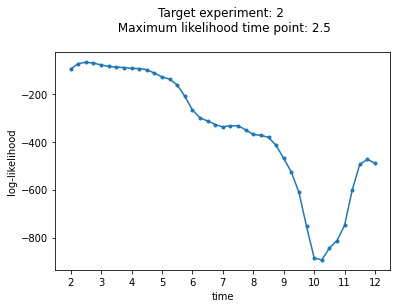

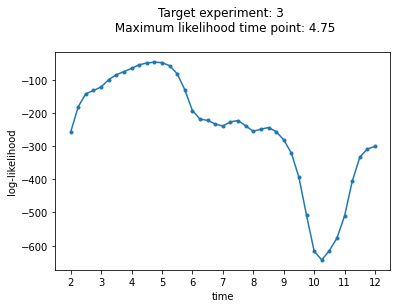

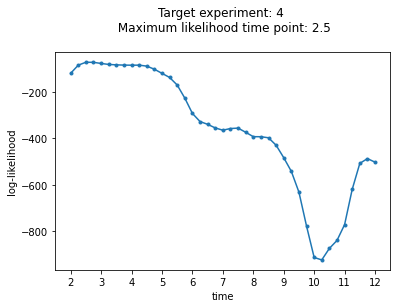

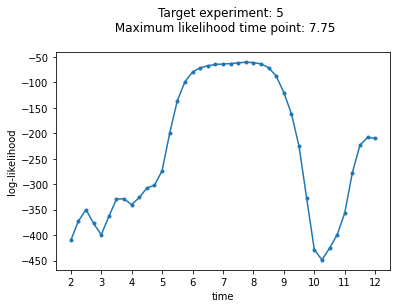

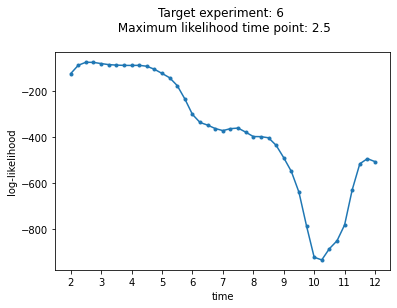

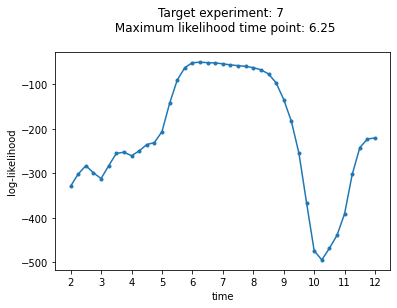

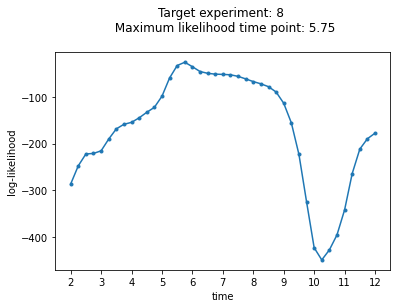

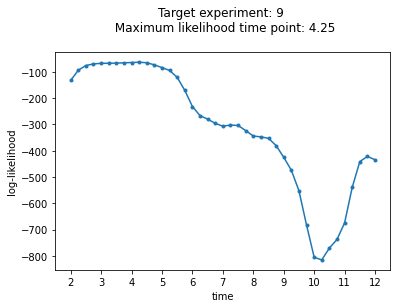

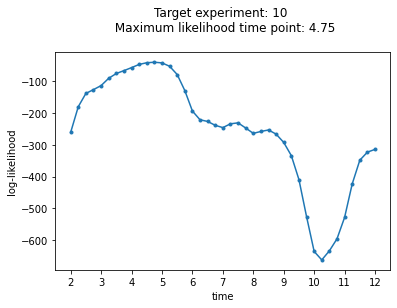

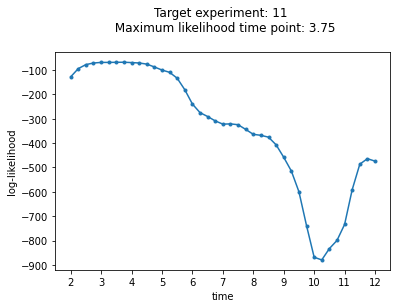

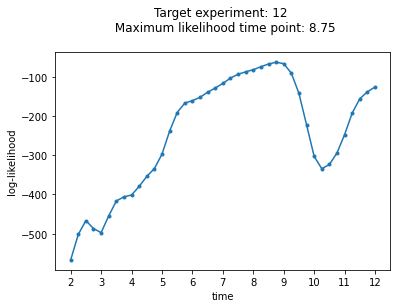

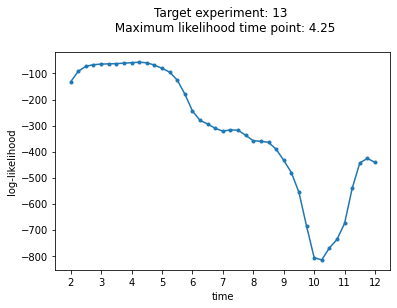

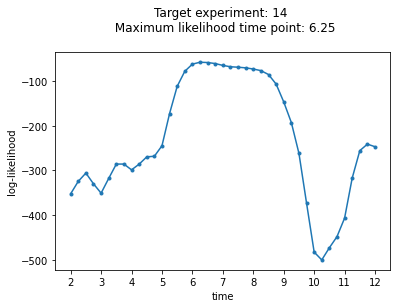

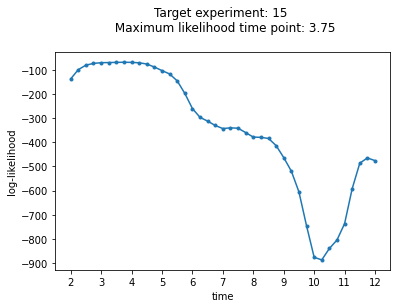

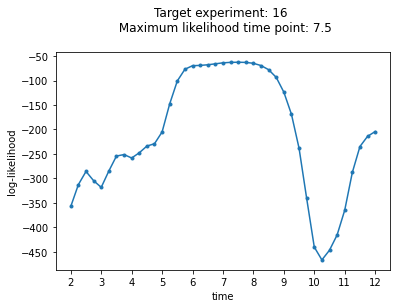

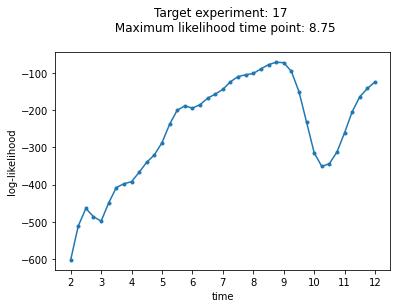

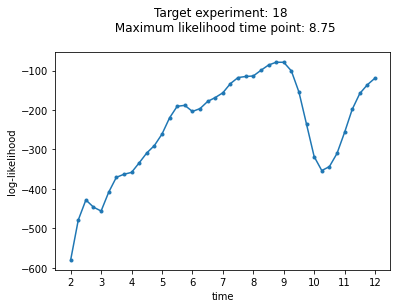

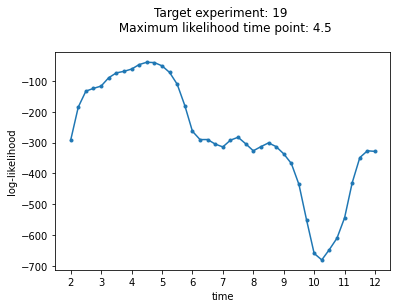

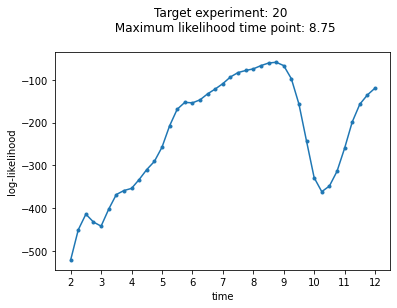

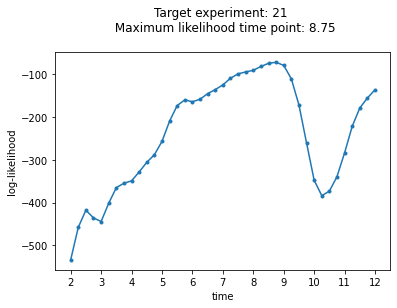

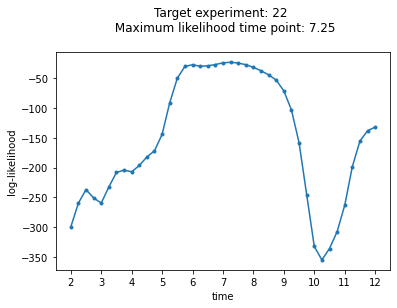

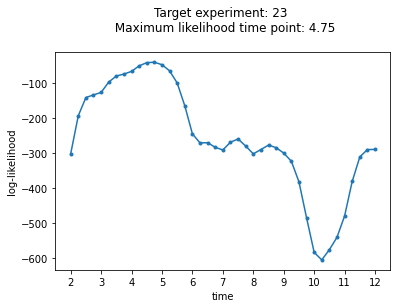

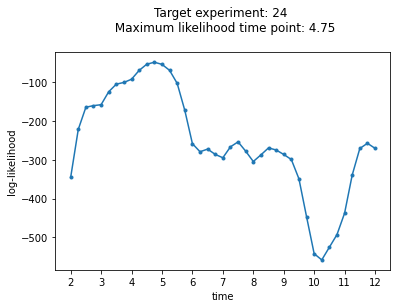

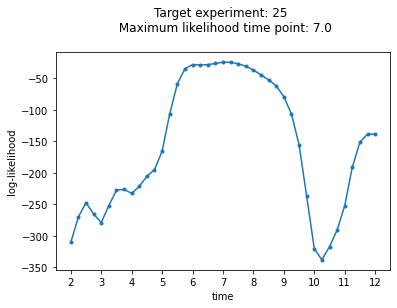

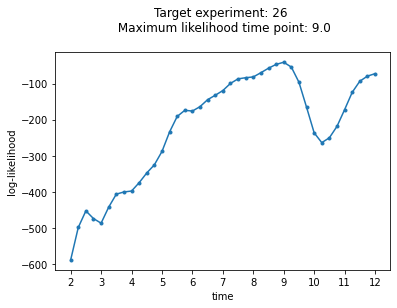

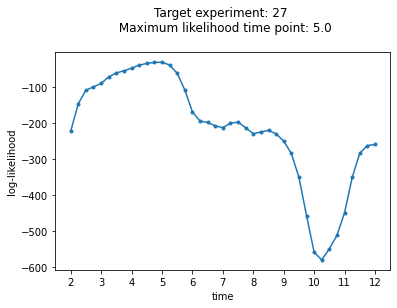

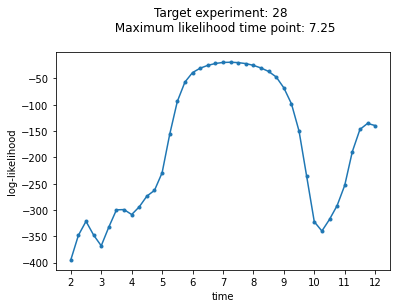

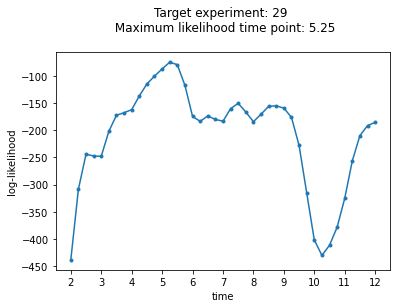

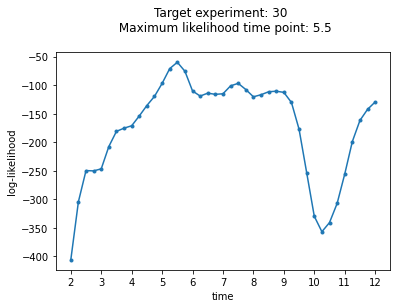

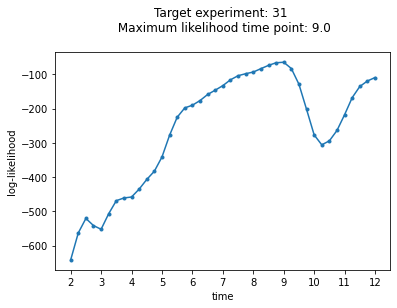

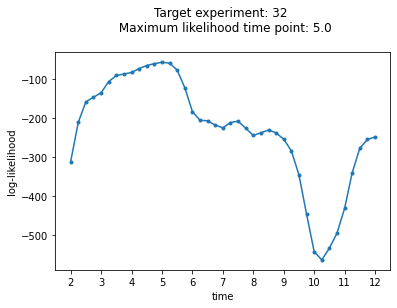

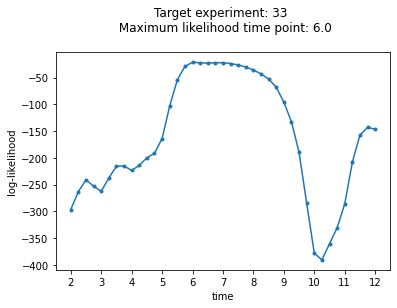

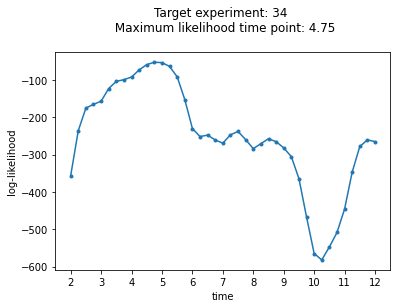

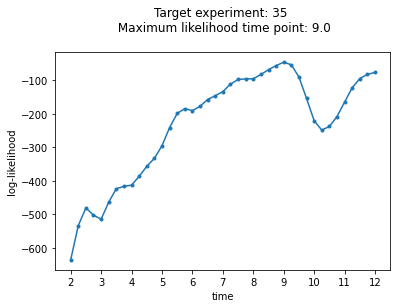

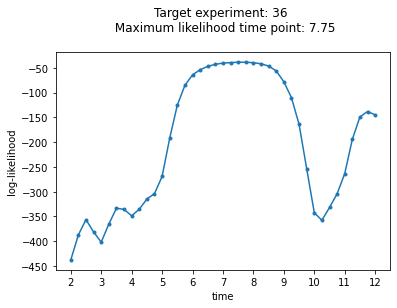

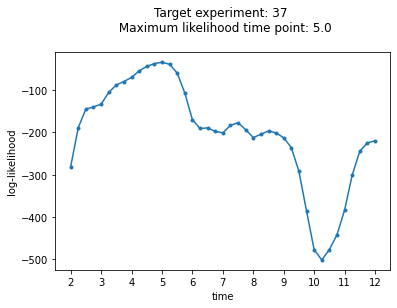

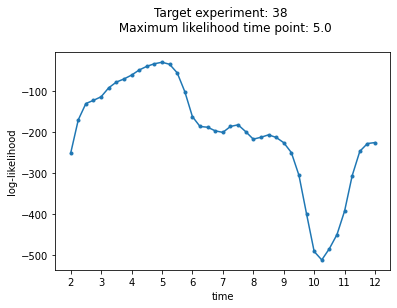

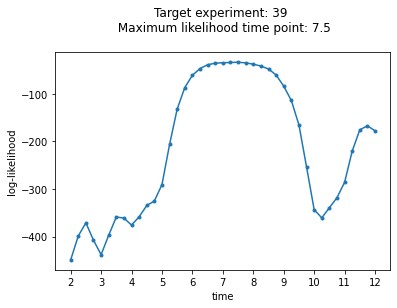

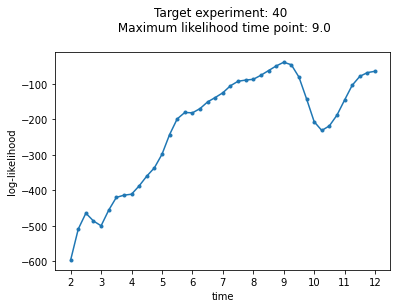

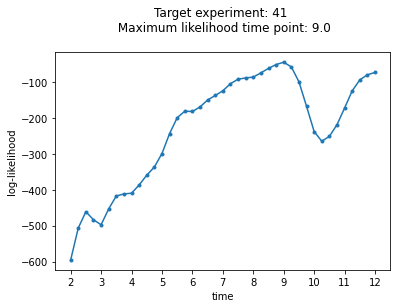

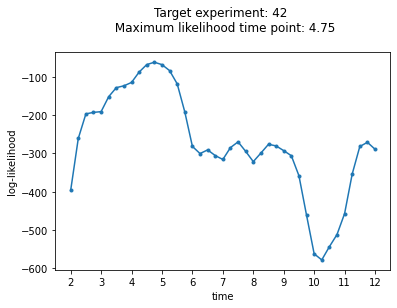

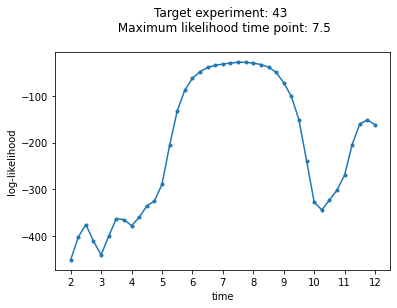

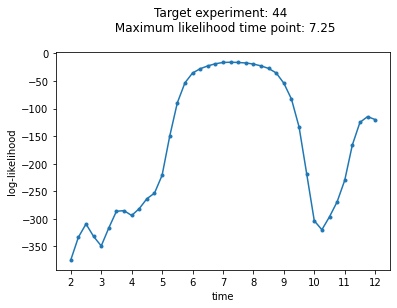

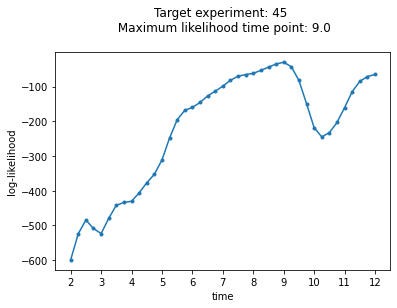

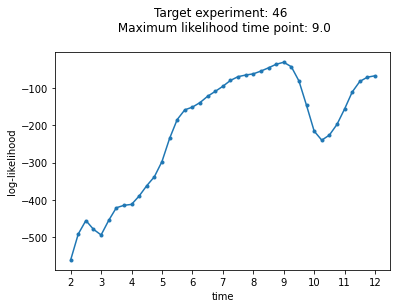

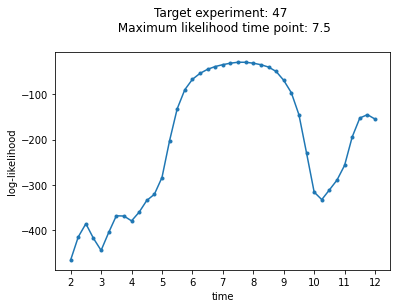

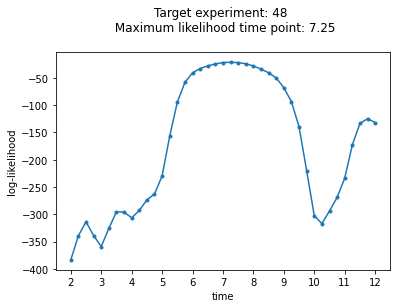

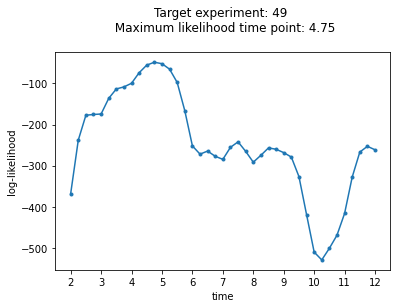

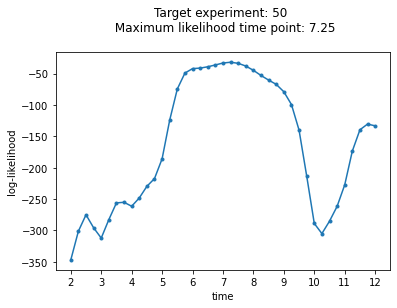

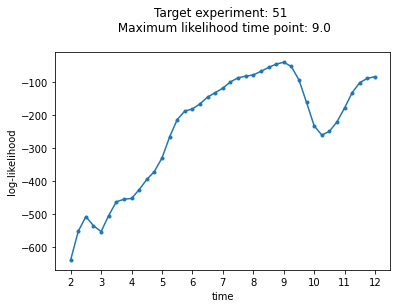

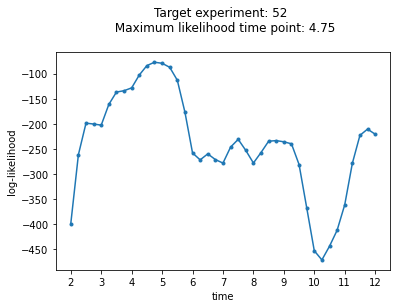

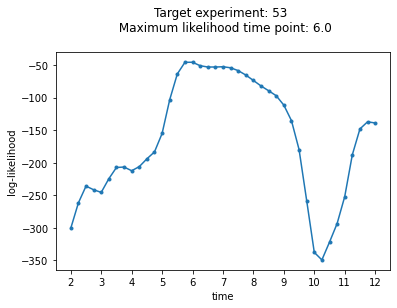

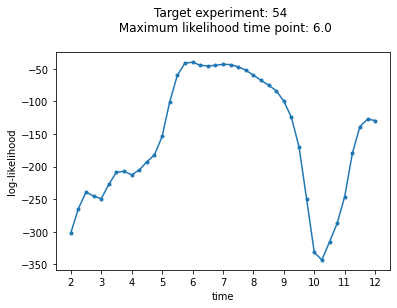

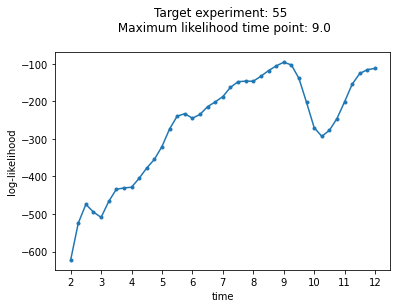

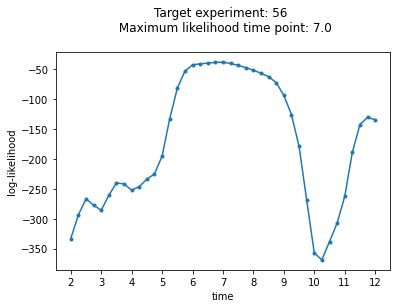

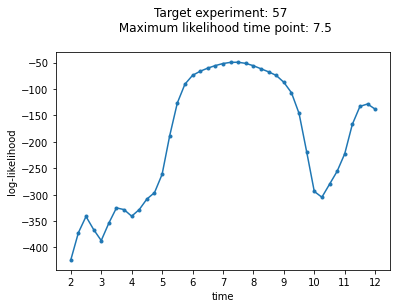

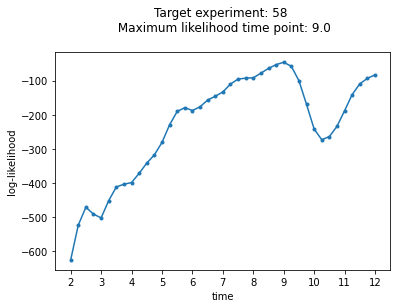

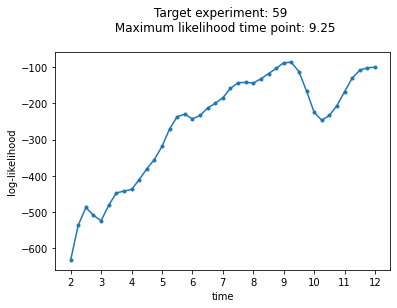

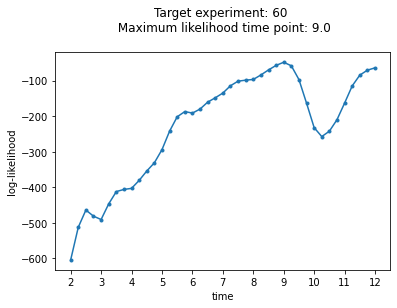

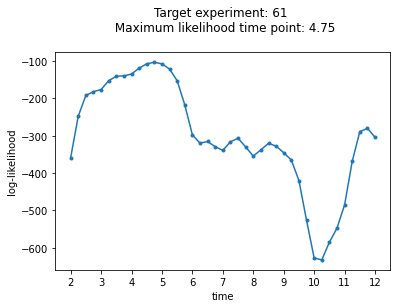

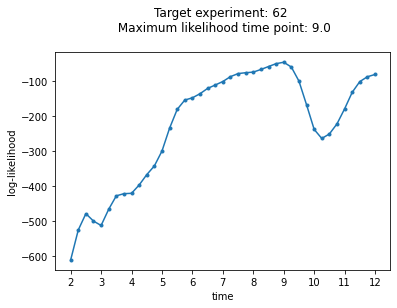

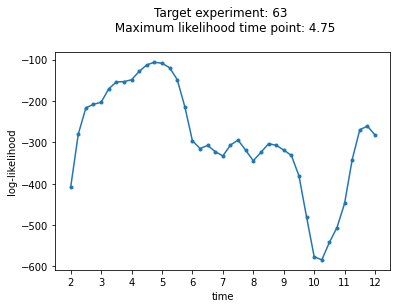

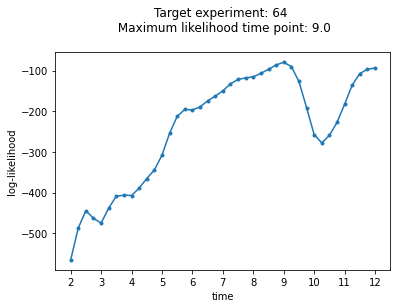

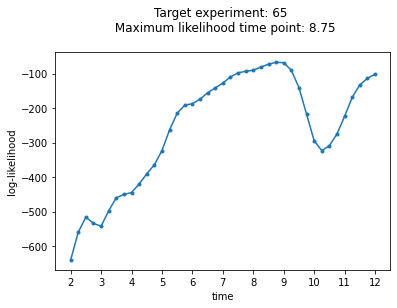

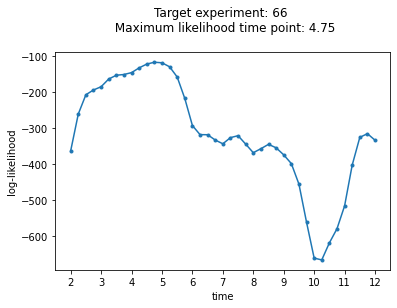

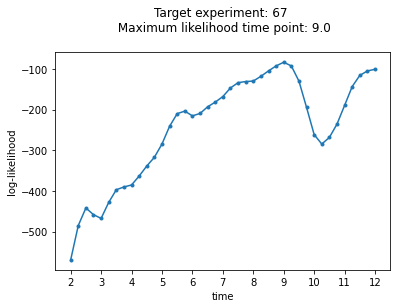

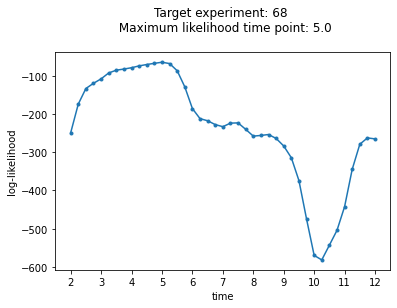

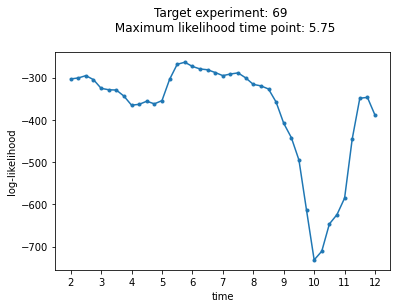

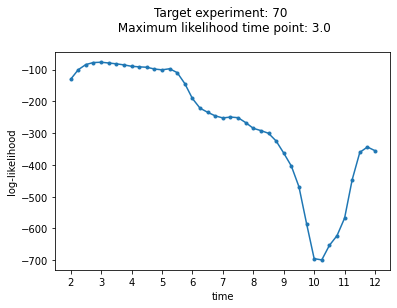

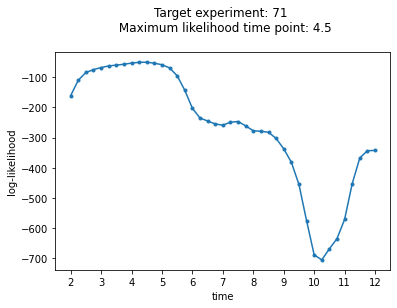

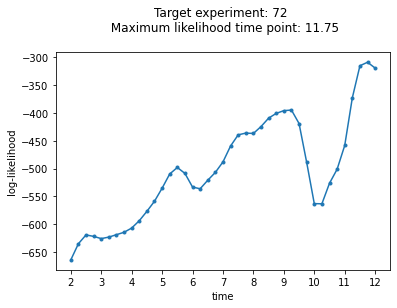

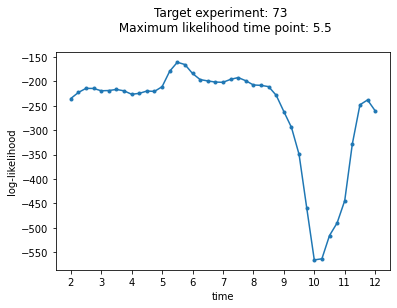

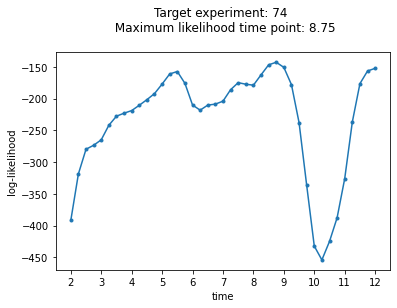

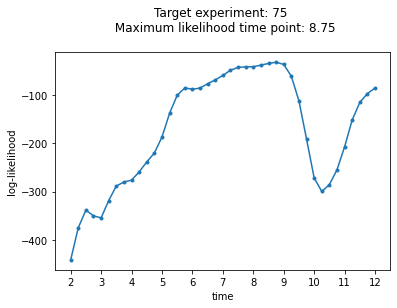

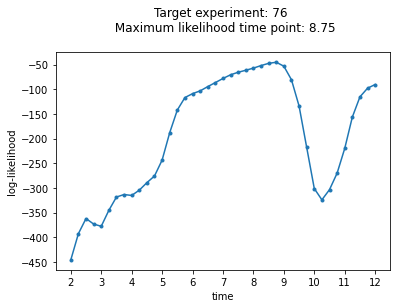

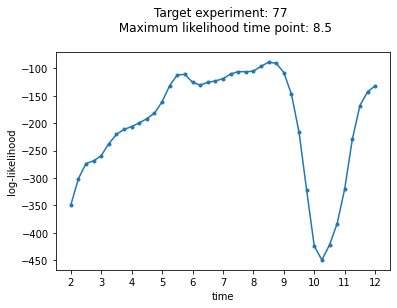

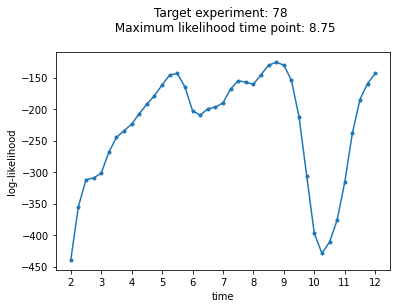

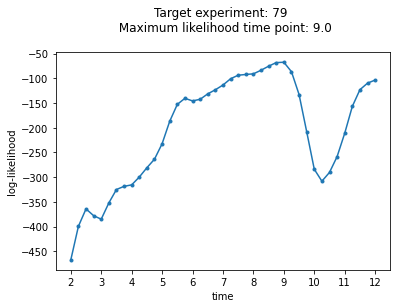

In [9]:
time_points_covered = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
number_of_replicates = 3


#array of time points with 15' space in the timeline 2h-12h
time_points_query = [e for e in list(np.arange(2, 12.25, 0.25))] # length: 41


predictions = time_annotation_method(reference_time_series, 
                              target_experiments, 
                              time_points_covered, 
                              number_of_replicates, 
                              time_points_query,
                              common_genes,
                              ls_upper=12, 
                              ls_lower=1,
                              epsilon_filter=2)

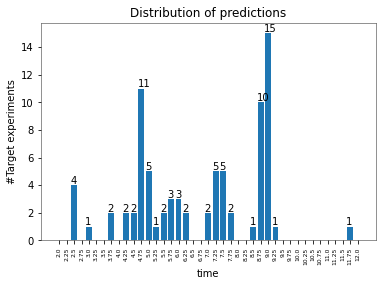

In [29]:
plt.rcParams['axes.facecolor'] = 'white'
plt.grid(False)
plt.rcParams["axes.edgecolor"] = "0.15"
plt.rcParams["axes.linewidth"]  = 0.5

predictions_str = [x for _,x in sorted(zip(predictions,[str(a) for a in predictions]))]
x = [a for i, a in enumerate(predictions_str) if i == predictions_str.index(a)]
y = [predictions_str.count(a) for a in x]

x1 = np.array([str(round(e,2)) for e in time_points_query])
y1 = [y[x.index(x1[i])] if x1[i] in x else 0 for i in range(len(x1)) ]

plt.bar(x1,y1)
plt.xlabel('time')
plt.ylabel('#Target experiments')
plt.title("Distribution of predictions")
plt.xticks(rotation=90,fontsize=6)

for i, v in enumerate(y1):
    if v == 0:
        continue
    plt.text(i-0.5, v + 0.1, str(v))

plt.show()